In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import os
from sklearn.metrics import r2_score

# from pynufft import NUFFT_cpu

import sys
sys.path.append("../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.transform.transform import FourierTransform, FFT, Regression
from mfilter.filter.mfilter import mfilter

In [2]:
# frequency grid
def f_grid(t, gamma=1, f_max=None, f_min=None):
    if f_max is None:
        f_max = 0.5 * t.average_fs
    if f_min is None:
        f_min = 1/t.duration
    df = f_min / gamma
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

def micro_lens(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm
    
def scores(y_trues, y_predicts):
    r2 = []
    for y_true, y_pred in zip(y_trues, y_predicts):
        r2.append(r2_score(y_true, y_pred))
        
    return r2

def plot_freqs(orig_data, orig_time, times, fts, freqs, recon_datas, labels=["FFT", "SGD"], 
               titles=["FT real", "FT imag.", "FT abs.", "Data"], 
               xaxis=["x", "x", "x", "x"], main_title="A title"):
    fsize=14
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 7))
    fig.suptitle(main_title, fontsize=fsize)
    ax4.plot(orig_time, orig_data, "k.", label="Original Data.")
    for t, ft, f, d, lb in zip(times, fts, freqs, recon_datas, labels):
        ax1.plot(f, np.real(ft), label="FT-{}".format(lb))
        ax2.plot(f, np.imag(ft), label="FT-{}".format(lb))
        ax3.plot(f, np.abs(ft), label="FT-{}".format(lb))
        ax4.plot(t, d, label="data-from-{}".format(lb))
        
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    for x, ttl, ax in zip(xaxis, titles, [ax1, ax2, ax3, ax4]):
        ax.set_xlabel(x, fontsize=fsize)
        ax.set_title(ttl, fontsize=fsize)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    
    
# read file
def read_file():
     # folder MLensing with the files should be placed out 
     # of the root file of the project (the one with the .git)
    return glob.glob("../../MLensing/*.mjd")

def read_data(files, j, ini, end, normalize_time=False):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ") # read the table
    a.columns = ["MJD", "Mag", "err"] # name the columns
    times = TimesSamples(a["MJD"][ini:end]) # read the times in MJD
    times -= times.min() # normalize to 0, this give us units of days
    times *= days_to_sec # transform to units of seconds
    if normalize_time:
        print("before normalize, we get an average sampling rate of:", 
              times.average_fs, "samples per seconds")
        times *= times.average_fs # normalize to units of samples (for digital signals)
        print("after normalize, we get an average sampling rate of:", times.average_fs, 
              "samples per cycles \n with this, perfect reconstruction is guaranteed " +
              "possible for a bandlimit of: ", times.average_fs/2)
        
    data = TimeSeries(a["Mag"][ini:end], times=times) # get the magnitude
    data -= np.median(data) # normalize the magnitud to 0 (the center goes to 0).
    err =  a["err"].tolist()[ini:end] # get the error
    return times, data, err

# using the chi statistic

def power_chisq(htilde, stilde, num_bins, times, transformer, psd=None, **kwargs):
    
    bins = power_chisq_bins(htilde, num_bins, psd=psd)
    
    
    snr, corr, norm = mfilter(times, htilde, stilde, transformer, psd=psd, full=True)
    
    return power_chisq_from_precomputed(corr, norm, snr, bins, times, transformer, **kwargs), len(bins)

def power_chisq_bins(htilde, num_bins, psd=None):
    sigma_vec = sigmasq_series(htilde, psd=psd)
    
    return power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins)

def sigmasq_series(htilde, psd=None):
    autocorr = htilde.conj() * htilde
    if psd is not None:
        autocorr /= psd
    return autocorr.cumsum()

def power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins):
    sigmasq = sigma_vec[len(sigma_vec)-2]
    edge_vec = np.arange(0, num_bins) * sigmasq / num_bins
    bins = np.searchsorted(sigma_vec, edge_vec, side='right')
    bins = np.append(bins, len(sigma_vec) - 1)
    bins = np.unique(bins)
#     if len(bins) != num_bins + 1:
#         print("using {} bins instead of {}".format(len(bins), num_bins))
    return bins

def power_chisq_from_precomputed(corr, norm, snr, bins, times, transformer, **kwargs):
    qtilde = FrequencySeries(np.zeros(len(corr)), frequency_grid=corr.frequency_object, dtype=corr.dtype,
                            epoch=corr.epoch)
    chisq = TimeSeries(np.zeros(len(snr)), times=snr.times, dtype=snr.dtype, epoch=snr.epoch)
    num_bins = len(bins) - 1
    
    for j in range(num_bins):
        k_min = int(bins[j])
        k_max = int(bins[j+1])
        qtilde[k_min:k_max] = corr[k_min:k_max]
        q = qtilde.to_timeseries(transformer)
        qtilde.fill(0)
        chisq += q.squared_norm()
        
    chisq = (chisq * num_bins - snr.squared_norm()) * (norm ** 2)
    chisq = TimeSeries(chisq, times=snr.times, epoch=snr.epoch)
    return chisq

def weighted_snr(snr, chisq):
    new_snr = np.ones(len(snr)) * 1j
    for i in range(len(chisq)):
        new_snr[i] = snr[i]
        if chisq[i] > 1:
            new_snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
    return new_snr



# define constants
reg = SGDRegression(alpha=10**(-4), max_iter=1000, penalty="l2", l1_ratio=0.5, tol=0.001)
N = 800
j = 10 # the particular observation to use, j={5, 9, 14} gives bad results 
ini = 0 # init of a range of the observations, we use the whole data
end = -1 # end of a range of the observation, we use the whole data
days_to_sec = 1 * 24 * 60 * 60 # transformation from days to seconds
sec_to_days = 1 /(60 * 60 * 24) # transformation from seconds to days

fs: 0.3326747724460931
teoretical match should give a time of match (offset) of:  1323.7694505


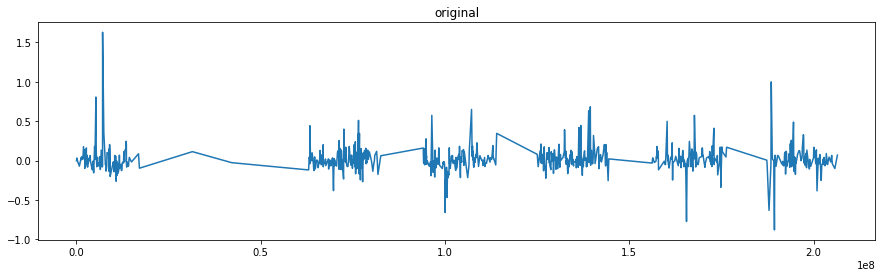

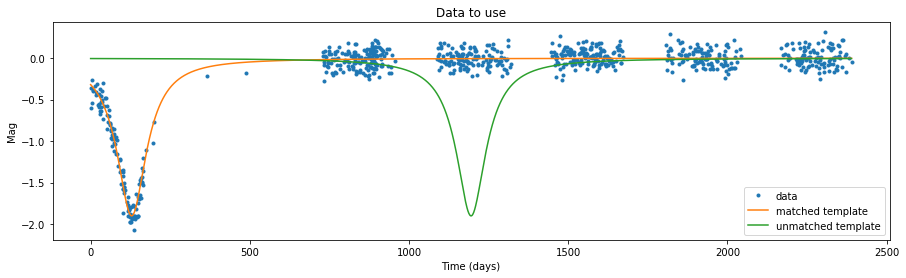

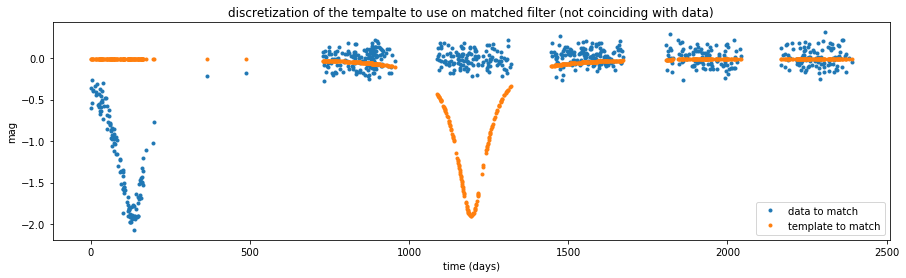

In [26]:
files = read_file()
times, data, err = read_data(files, j, ini, end, normalize_time=False)
plt.figure(figsize=(15, 4))
plt.plot(times, data)
plt.title("original")
times *= sec_to_days
# times = TimesSamples(np.linspace(times.min(), times.max(), len(times)))
N = len(times)
fs = times.average_fs
print("fs:", fs)
te = 30
fs = 13.2 
u0 = 1.2
L = 93
data = TimeSeries(micro_lens(u0, times[L]-5, te, fs, times) + np.random.normal(0, 0.1, len(times)), times=times)
# data = TimeSeries(np.sin(2 * np.pi * 0.01 * times) + np.sin(2 * np.pi * 1 * times) + np.random.normal(0, 0.1, len(times)), times=times)
# data = TimeSeries(np.random.normal(0, 0.2, len(times)), times=times)
uniform_time = TimesSamples(np.linspace(times.min(), times.max(), 2*N))
temp_matched = TimeSeries(micro_lens(u0, times[L]-5, te, fs, uniform_time), times=uniform_time)

def temp(t0, times):
    return TimeSeries(micro_lens(u0, t0, te, fs, times), times=times)

unmatched_template = temp(times.duration/2, uniform_time)

plt.figure(figsize=(15, 4))
plt.plot(times, data, '.', label="data")
plt.plot(uniform_time, temp_matched, label="matched template")
plt.plot(uniform_time, unmatched_template, label="unmatched template")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Mag")
plt.title("Data to use")

template = temp(times.duration/2, times)
plt.figure(figsize=(15, 4))
plt.plot(times, data, '.', label='data to match')
plt.plot(times, template, '.', label='template to match')
plt.legend()
plt.title("discretization of the tempalte to use on matched filter (not coinciding with data)")
plt.xlabel("time (days)")
plt.ylabel('mag')

teoretical_time = max(times) + times[L]-5 - times.duration/2
print("teoretical match should give a time of match (offset) of: ", teoretical_time)

<class 'mfilter.types.frequencyseries.FrequencySamples'>
<class 'mfilter.types.frequencyseries.FrequencySamples'>
1590
0.0006289308176100629 0.0006289308176100629
0.6653495448921862
mean value is:  0.36848318235130606
match happens at time:  1319.6904050000012
And teoretical match should give a time of match (offset) of:  1323.7694505


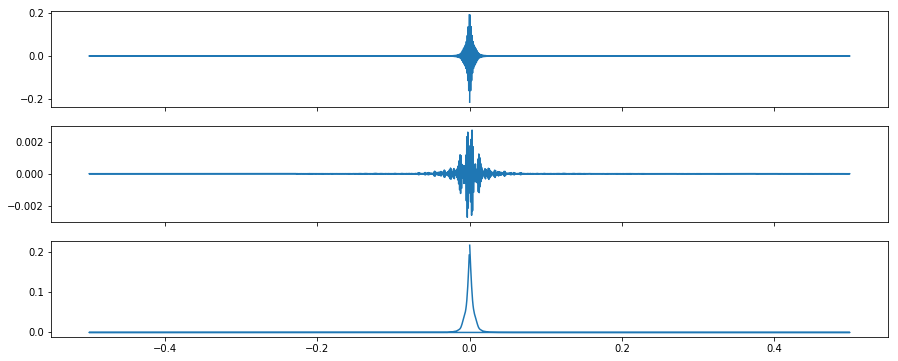

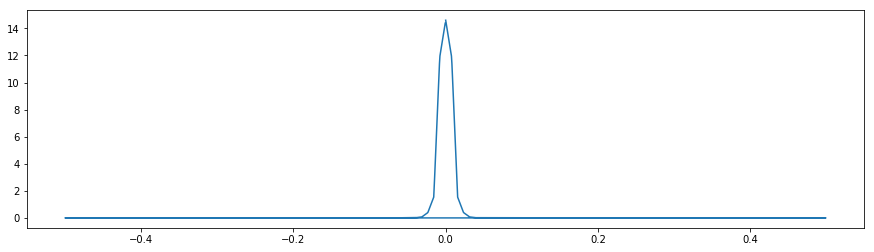

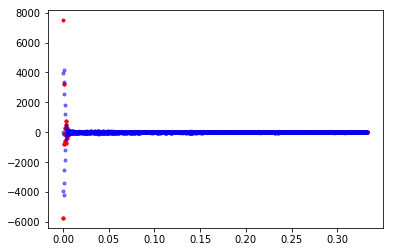

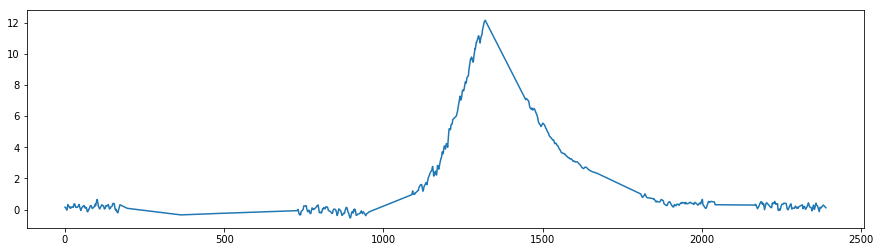

In [27]:
# we need to interpolate data
beta = 2
i_times = TimesSamples(np.linspace(times.min(), times.max(), beta * len(times)))
i_data = TimeSeries(np.interp(i_times, times, data), times=i_times)
i_template = TimeSeries(np.interp(i_times, times, template), times=i_times)
fs = i_times.average_fs

# and also normalize time to digital signals
i_n_times = TimesSamples(i_times * i_times.average_fs)
i_n_data = TimeSeries(i_data.value, times=i_n_times)
i_n_template = TimeSeries(i_template.value, times=i_n_times)

# define the transformer to use
tr = FFT(i_n_times)

# get the fourier transform
htilde_fft = i_n_template.to_frequencyseries(tr)
htilde_fft /= i_times.average_fs
stilde_fft = i_n_data.to_frequencyseries(tr)
stilde_fft /= i_times.average_fs
N = len(i_n_data)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15, 6), sharex=True)
ax1.plot(tr.get_frequency(N=N), np.real(htilde_fft) / N)
ax2.plot(tr.get_frequency(N=N), np.imag(htilde_fft) / N)
ax3.plot(tr.get_frequency(N=N), np.abs(htilde_fft) / N)

# and the psd, in this case, using lomb-welch
psd, freqs = mlab.psd(i_n_data)
# interpolatin to our frequencies
psd = np.interp(np.abs(tr.get_frequency(N=N)), freqs, psd)
psd = FrequencySeries(psd, frequency_grid=FrequencySamples(tr.get_frequency(N=N)), 
                      epoch=data.epoch)

plt.figure(figsize=(15, 4))
plt.plot(tr.get_frequency(N=N), psd)
print(len(psd))
# finally, calculate the SNR
uniform = True
i_n_snr, corr, norm = mfilter(i_n_times, stilde_fft, htilde_fft, tr, psd=psd, uniform=uniform, full=True)
print(fs)
plt.figure()
plt.plot(abs(tr.get_frequency(N=N)) * fs, corr.real, 'r.')
plt.plot(abs(tr.get_frequency(N=N)) * fs, corr.imag, 'b.', alpha=0.5)
# and go back to original time, the normalization in time doesnt affect the values
snr = np.interp(times, i_times, i_n_snr)

plt.figure(figsize=(15, 4))
plt.plot(times, snr.real)
print("mean value is: ", np.median(snr.real))
print("match happens at time: ", times[np.argmax(snr.real)])
print("And teoretical match should give a time of match (offset) of: ", teoretical_time)



# first define the transform instances
# fft = FFT() # FFT transformer, beta is a factor on the number of interpolated points (beta * N)


# # get the fourier transforms
# htilde_fft = template.to_frequencyseries(fft)
# stilde_fft = data.to_frequencyseries(fft)

# # get the psd, we interpolate data and use mlab.psd the interpolate frequencies
# interp_data = np.interp(fft.reg_times, fft.times, data)
# psd, freqs = mlab.psd(interp_data)
# psd = np.interp(np.abs(fft.get_frequency(N=len(times))), freqs, psd)
# psd = FrequencySeries(psd, frequency_grid=FrequencySamples(fft.get_frequency(N=len(times))), 
#                       epoch=data.epoch)
# plt.figure()
# plt.plot(fft.get_frequency(N=len(times)), psd)
# uniform = True
# snr = mfilter(times, stilde_fft, htilde_fft, fft, psd=psd, uniform=uniform)

# if False:
#     time_plot = fft.reg_times
# else:
#     time_plot = times

# time_match_fft = time_plot[np.argmax(np.abs(snr))]
# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
# ax1.plot(time_plot, np.abs(snr), '.')

# ax2.plot((times + time_match_fft) % max(times), template, '.')
# ax2.plot(times, data, '.')
# print("found match at offset {}, and theoritical was {}".format(time_match_fft, teoretical_time))

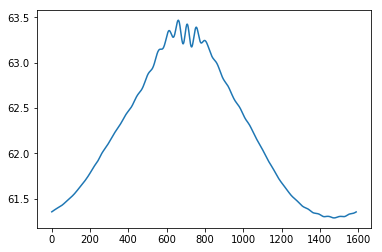

In [28]:
divs = 40
chsq_reg, n_bins = power_chisq(htilde_fft, stilde_fft, divs, i_n_times, tr, reg=reg)
chsq_reg /= (n_bins * 2) - 2
snr_t = i_n_snr.copy()
snr_reg = weighted_snr(snr_t, chsq_reg)
plt.plot(i_n_times, chsq_reg.real)

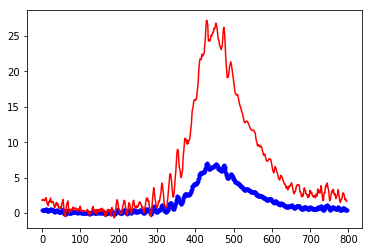

In [84]:
plt.plot(i_n_times, snr_reg.real, 'b.')
plt.plot(i_n_times, i_n_snr.real, 'r')

In [63]:
snr = np.interp(times, i_times, snr_reg)

In [64]:
print(times[np.argmax(abs(snr))])

1319.6904050000012
